In [1]:
!pip install deep_translator


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.9 MB/s eta 0:00:00


#SENTIMENT ANALYSIS PROJECT USING NLP

In [2]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import nltk # Import the Natural Language Toolkit library for text processing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer # Import VADER for sentiment analysis

from sklearn.pipeline import Pipeline # Import Pipeline for creating a sequence of data processing steps
from deep_translator import GoogleTranslator # Import GoogleTranslator for translating text to English
from sklearn.preprocessing import FunctionTransformer # Import FunctionTransformer for applying a custom function in a pipeline
import joblib # Import joblib for saving and loading Python objects

In [3]:
nltk.download('stopwords') # Download stopwords list
nltk.download('wordnet') # Download WordNet for lemmatization
nltk.download('vader_lexicon') # Download VADER lexicon for sentiment analysis

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [4]:
df=pd.read_excel('P597 DATASET.xlsx')

In [5]:
df.shape #we have title , rating, body

(1440, 3)

In [6]:
df.isnull().sum()

,0
title,0
rating,0
body,0


In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
df.describe(include='all')

,title,rating,body
count,1440,1440.000000,1440
unique,1351,NaN,1440
top,Value for money,NaN,Good phone for budget buyers. Sound quality is...
freq,16,NaN,1
mean,NaN,3.173611,NaN
std,NaN,1.584453,NaN
min,NaN,1.000000,NaN
25%,NaN,1.000000,NaN
50%,NaN,4.000000,NaN
75%,NaN,5.000000,NaN


In [9]:
# Combine title and body
df['full_text'] = df['title'].astype(str) + ' ' + df['body'].astype(str)

## Create stopword list and lemmatizer

In [10]:
# Initialize the WordNet Lemmatizer
lemmatizer=WordNetLemmatizer()

In [11]:
# 1. Get the standard English stopword list
stop_words = set(stopwords.words('english'))

# 2. Define negative words to KEEP
# We remove these from the stopword list
negative_stopwords = {
    'no', 'not', 'nor', 'don', "don't", 'ain', 'aren', "aren't", 'couldn', "couldn't",
    'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't",
    'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't",
    'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't",
    'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"
}
# 3. Create the final stopword list
final_stop_words = stop_words - negative_stopwords

In [12]:
def full_preprocess(text):
  # Translate to English
  text = text.apply(lambda x: "" if pd.isnull(x) or str(x).strip() == ""
                    else GoogleTranslator(source='auto', target='en').translate(x))

  text = text.str.lower()   # Convert text to lowercase
  text = text.str.replace(r"http\S+|www\S+|https\S+", "", regex=True)  # Remove URLs
  text = text.str.replace(r"@\w+", "", regex=True)   # Remove mentions
  text = text.str.replace(r"#", "", regex=True)      # Remove hashtag symbol (keep the word)
  text = text.str.replace(r"\d+", "", regex=True)    # Remove numbers
  text = text.str.replace(r"[^\w\s]", "", regex=True)  # Remove punctuation

  # Remove emojis
  text = text.apply(lambda x: re.sub(r'[\U00010000-\U0010ffff]', '', x))

  # Lemmatize words and remove stopwords
  text = text.apply(lambda x: ' '.join([
      lemmatizer.lemmatize(word)
      for word in x.split() if word not in final_stop_words
  ]))

  # Remove non-ASCII characters and extra spaces
  text = text.apply(lambda x: ' '.join(re.sub(r'[^\x00-\x7F]+',' ', x).split()))
  text = text.str.strip().str.replace(r"\s+", " ", regex=True)  # Clean up spaces

  return text

In [13]:
preprocess_pipeline = Pipeline([
    ('text_preprocessor', FunctionTransformer(full_preprocess, validate=False))
])

In [14]:
df['full_text1'] =preprocess_pipeline.fit_transform(df['full_text'])

In [15]:
df[['full_text1','full_text']].head(250)

,full_text1,full_text
0,horrible product disappointed overall performa...,Horrible product Very disappointed with the ov...
1,camera quality not like megapixel camera quali...,Camera quality is not like 48 megapixel Camera...
2,overall got mobile launch datebattery must app...,"Overall Got the mobile on the launch date,Batt..."
3,big no doesnt work ghz wifi frequency ghz old ...,A big no from me 1. It doesn't work with 5.0GH...
4,put money somewhere else not worth buyingfault...,Put your money somewhere else Not worth buying...
...,...,...
245,overall beast phone according battery backup p...,Overall beast phone according to battery backu...
246,phone good mid level range overall phone ok gb...,Phone is good for mid level range Overall phon...
247,think twice buying using phone past month neve...,Think twice before buying I am using this pho...
248,damaged product reshived damaged product reshi...,Damage product reshived Damage product reshive...


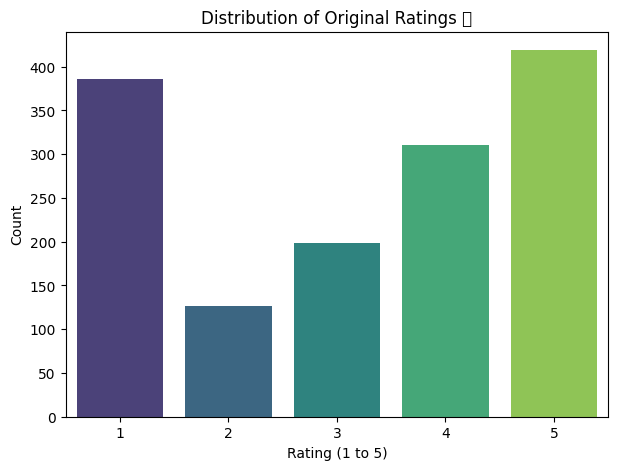

In [16]:
import seaborn as sns # Import seaborn for enhanced visualizations

# --- Rating Distribution ---
plt.figure(figsize=(7, 5))
sns.countplot(x='rating', data=df, palette='viridis')
plt.title('Distribution of Original Ratings ⭐')
plt.xlabel('Rating (1 to 5)')
plt.ylabel('Count')
plt.show()

In [17]:
df.shape

(1440, 5)

In [18]:
# Display the first few rows of the DataFrame to show the new 'full_text' column
df.head()

,title,rating,body,full_text,full_text1
0,Horrible product,1,Very disappointed with the overall performance...,Horrible product Very disappointed with the ov...,horrible product disappointed overall performa...
1,Camera quality is not like 48 megapixel,3,Camera quality is low,Camera quality is not like 48 megapixel Camera...,camera quality not like megapixel camera quali...
2,Overall,4,"Got the mobile on the launch date,Battery must...","Overall Got the mobile on the launch date,Batt...",overall got mobile launch datebattery must app...
3,A big no from me,1,1. It doesn't work with 5.0GHz WiFi frequency....,A big no from me 1. It doesn't work with 5.0GH...,big no doesnt work ghz wifi frequency ghz old ...
4,Put your money somewhere else,1,"Not worth buying....faulty software, poor disp...",Put your money somewhere else Not worth buying...,put money somewhere else not worth buyingfault...


## Intialize sentiment analyzer(VADER)

In [19]:
# Initialize the VADER Sentiment Intensity Analyzer
sia=SentimentIntensityAnalyzer()

In [20]:
# Calculate the VADER compound sentiment score for each entry in the 'full_text' column
df['sentiment_score']=df['full_text1'].apply(lambda x: sia.polarity_scores(x)['compound'])

## Calculate sentiment score for each review

In [21]:
# Display the calculated sentiment scores
df['sentiment_score']

,sentiment_score
0,-0.7650
1,-0.4956
2,0.1027
3,-0.9114
4,-0.8033
...,...
1435,0.8126
1436,-0.8908
1437,0.9340
1438,-0.7509


## Convert Sentiment score to label
## > 0.05 -> positive | < -0.05-> Negative | else Neutral

In [22]:
# Classify the sentiment based on the compound score
# 'positive' if score > 0.05, 'negative' if score < -0.05, otherwise 'neutral'
df['sentiment']=df['sentiment_score'].apply(lambda x: 'positive' if x>0.05 else ('negative' if x<-0.05 else 'neutral'))

In [23]:
# Print the distribution of the sentiment labels
print("sentiment distribution")
print(df['sentiment'].value_counts())

sentiment distribution
sentiment
positive    917
negative    485
neutral      38
Name: count, dtype: int64


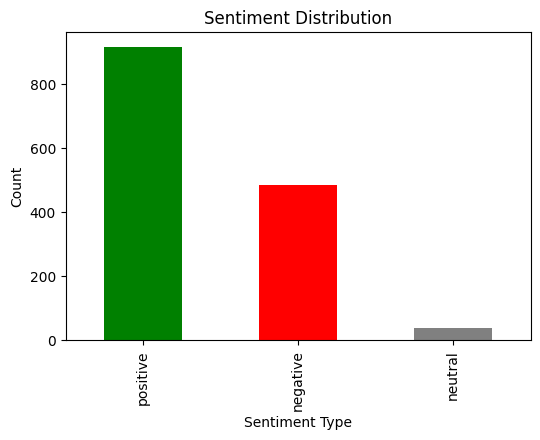

In [24]:
plt.figure(figsize=(6,4))
df['sentiment'].value_counts().plot(kind='bar', color=['green', 'red', 'gray'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Type')
plt.ylabel('Count') # Set the label for the y-axis
plt.show() # Display the plot

In [25]:
# Assign the 'full_text' column to X (features) and 'sentiment' column to y (target)
X= df['full_text1']
y = df['sentiment']

#Train-Test Split

In [26]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [27]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)


In [28]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1152,)
(288,)
(1152,)
(288,)


In [29]:
# Convert text data into DataFrame (required by RandomOverSampler)
train_df = pd.DataFrame({'text': x_train, 'label': y_train})

In [30]:
train_df

,text,label
1148,excellent product like product battery life fi...,positive
677,minor lag ui noticed device awesome u get got ...,negative
221,think first phone worth purchaseand best budge...,positive
113,value money superb great speed photo clarity l...,positive
845,get pay good no regret doesits worth pay happy...,positive
...,...,...
1095,awesome mobile cost like awesome mobile cost,positive
1130,samsung best product range not heavy driver mu...,positive
1294,worst ever phone amazon wrost phone dont ever ...,negative
860,not good option samsun received mobile launch ...,negative


#Handling Imbalanced Data (Oversampling)

In [31]:
from imblearn.over_sampling import RandomOverSampler

In [32]:
#Apply RandomOverSampler on training set only
oversample = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversample.fit_resample(train_df[['text']], train_df['label'])

In [33]:
print("Resampled sentiment distribution:")
print(y_train_resampled.value_counts())

Resampled sentiment distribution:
label
positive    728
negative    728
neutral     728
Name: count, dtype: int64


#Text Vectorization using TF-IDF

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [35]:
#Apply TF-IDF after oversampling
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [36]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_resampled['text'])
X_test_tfidf = tfidf_vectorizer.transform(x_test)

In [37]:

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

In [38]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#Model Building and  model Evaluation

### Model 1: Logistic Regression

In [39]:
log_model = LogisticRegression(C=10,max_iter=100,solver='lbfgs')
log_model.fit(X_train_tfidf, y_train_resampled )

LogisticRegression(C=10)

In [40]:
y_pred_log = log_model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Classification Report:")
print(classification_report(y_test, y_pred_log))

Accuracy: 0.8402777777777778
Classification Report:
              precision    recall  f1-score   support

    negative       0.74      0.79      0.77        91
     neutral       0.00      0.00      0.00         8
    positive       0.89      0.90      0.89       189

    accuracy                           0.84       288
   macro avg       0.54      0.56      0.55       288
weighted avg       0.82      0.84      0.83       288



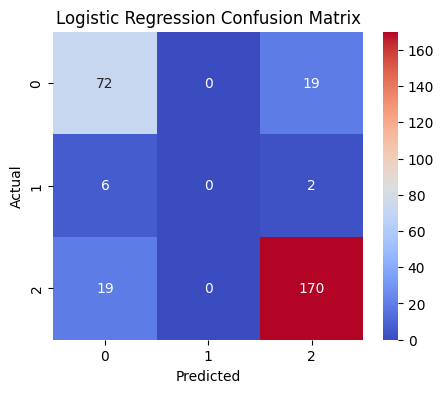

In [41]:
# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt='d', cmap='coolwarm')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Hyperparameter Tuning with GridSearchCV for logistic regression

In [42]:
log_params={'C':[0.01,0.1,1,10],'solver':['liblinear','lbfgs'],'max_iter':[100,500,1000]}
grid_search_log=GridSearchCV(log_model,log_params)
grid_search_log.fit(X_train_tfidf,y_train_resampled )
grid_search_log.best_params_

{'C': 10, 'max_iter': 100, 'solver': 'lbfgs'}

In [43]:
svm_model = LinearSVC(C=10)
svm_model.fit(X_train_tfidf, y_train_resampled)

LinearSVC(C=10)

In [44]:
y_pred_svm = svm_model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))


Accuracy: 0.8125
Classification Report:
              precision    recall  f1-score   support

    negative       0.73      0.71      0.72        91
     neutral       0.00      0.00      0.00         8
    positive       0.85      0.89      0.87       189

    accuracy                           0.81       288
   macro avg       0.53      0.54      0.53       288
weighted avg       0.79      0.81      0.80       288



In [45]:
svm_params={'C':[0.1,1,10]}
grid_search_svm=GridSearchCV(svm_model,svm_params)
grid_search_svm.fit(X_train_tfidf,y_train_resampled)
grid_search_svm.best_params_

{'C': 10}

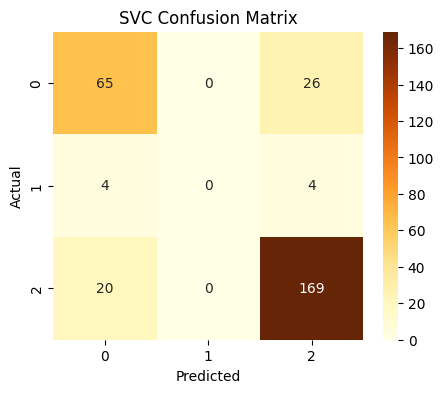

In [46]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='YlOrBr')
plt.title("SVC Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [47]:
knn_model = KNeighborsClassifier(n_neighbors=11,metric='euclidean',weights='distance')
knn_model.fit(X_train_tfidf, y_train_resampled)

KNeighborsClassifier(metric='euclidean', n_neighbors=11, weights='distance')

In [48]:

y_pred_knn = knn_model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:")
print(classification_report(y_test, y_pred_knn))


Accuracy: 0.7465277777777778
Classification Report:
              precision    recall  f1-score   support

    negative       0.67      0.58      0.62        91
     neutral       0.19      0.38      0.25         8
    positive       0.82      0.84      0.83       189

    accuracy                           0.75       288
   macro avg       0.56      0.60      0.57       288
weighted avg       0.76      0.75      0.75       288



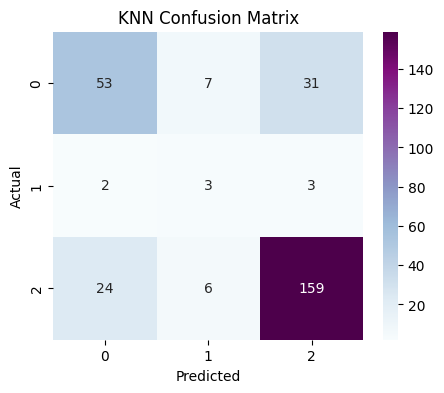

In [49]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', cmap='BuPu')
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [50]:
knn_params = {
    'n_neighbors': range(1,20),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'cosine']
}
grid_search_knn = GridSearchCV(knn_model, knn_params)
grid_search_knn.fit(X_train_tfidf, y_train_resampled)
grid_search_knn.best_params_

{'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}

In [51]:
nb_model = MultinomialNB(alpha=1, fit_prior= True)
nb_model.fit(X_train_tfidf, y_train_resampled)

MultinomialNB(alpha=1)

In [52]:
y_pred_nb = nb_model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:")
print(classification_report(y_test, y_pred_nb))

Accuracy: 0.8055555555555556
Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.58      0.68        91
     neutral       0.33      0.25      0.29         8
    positive       0.82      0.94      0.87       189

    accuracy                           0.81       288
   macro avg       0.65      0.59      0.61       288
weighted avg       0.80      0.81      0.79       288



In [53]:
nb_params = {
    'alpha': [1.0,2.0,3.0],
    'fit_prior': [True, False]
}
grid_search_nb = GridSearchCV(nb_model, nb_params)
grid_search_nb.fit(X_train_tfidf, y_train_resampled)
grid_search_nb.best_params_

{'alpha': 1.0, 'fit_prior': True}

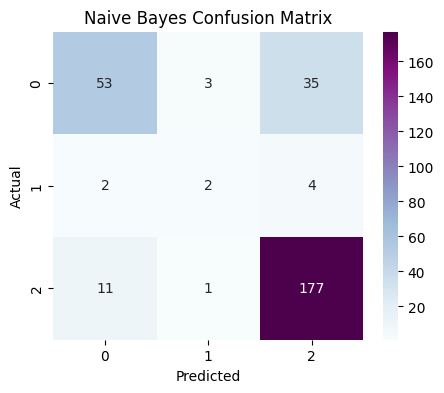

In [54]:

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt='d', cmap='BuPu')
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [55]:

from sklearn.ensemble import RandomForestClassifier

In [56]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_tfidf, y_train_resampled)


RandomForestClassifier()

In [57]:
y_pred_rf = rf_model.predict(X_test_tfidf)

In [58]:
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.8125
Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.74      0.73        91
     neutral       0.00      0.00      0.00         8
    positive       0.86      0.88      0.87       189

    accuracy                           0.81       288
   macro avg       0.53      0.54      0.53       288
weighted avg       0.79      0.81      0.80       288



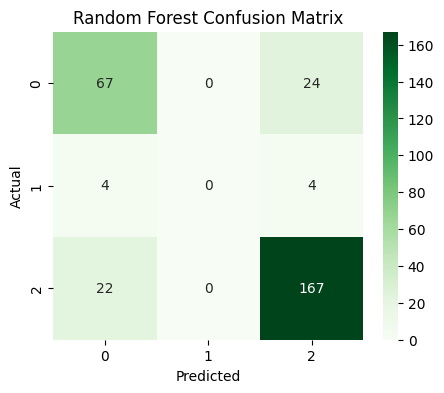

In [59]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

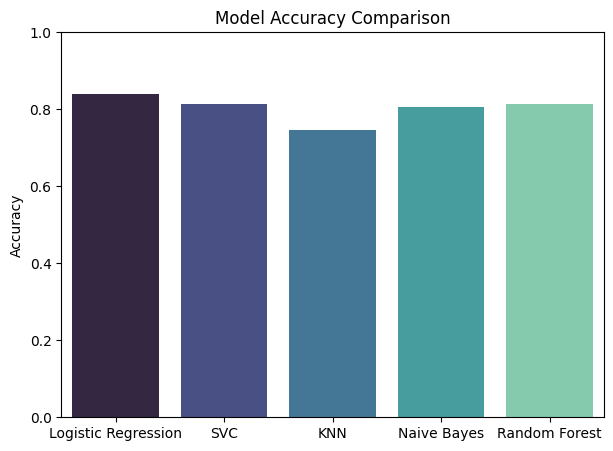

 Model Performance:
Logistic Regression: 0.8403
SVC: 0.8125
KNN: 0.7465
Naive Bayes: 0.8056
Random Forest: 0.8125


In [60]:
from sklearn.metrics import accuracy_score

models = {
    "Logistic Regression": log_model,
    "SVC": svm_model,
    "KNN": knn_model,
    "Naive Bayes": nb_model,
    "Random Forest": rf_model
}

results = {}
for name, model in models.items():
    y_pred = model.predict(X_test_tfidf)
    results[name] = accuracy_score(y_test, y_pred)

# Visualization
plt.figure(figsize=(7,5))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette='mako')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

print(" Model Performance:")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")


In [61]:
# AFTER testing your model accuracy and results:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import cloudpickle

# Create a FunctionTransformer for your text cleaning function
preprocess_transformer = FunctionTransformer(full_preprocess)

# Build the complete pipeline
full_pipeline = Pipeline([
    ('preprocess', preprocess_transformer),
    ('tfidf', tfidf_vectorizer),
    ('model', log_model)
])


In [64]:
import joblib

joblib.dump(Pipeline, "sentiment.pkl")
print("Full pipeline saved successfully as sentiments.pkl")

Full pipeline saved successfully as sentiments.pkl


In [ ]:
'''#Save everything (pipeline + preprocessing function) safely
with open("sentiments.pkl", "wb") as f:
        cloudpickle.dump(full_pipeline, f)
print("Full pipeline saved successfully as sentiments.pkl")'''

Full pipeline saved successfully as sentiments.pkl
